In [ ]:
pip install scikit-image

In [ ]:
import skimage

print("Versi scikit-image (skimage):", skimage.__version__)

In [ ]:
import cv2
import numpy as np
import glob
import os
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.transform import ProjectiveTransform, warp
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Fungsi untuk memperbanyak dataset dengan teknik augmentasi
def augment_data(input_dir, output_dir):
    # Membuat direktori output jika belum ada
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop melalui setiap folder A-Z
    for folder_name in range(ord('A'), ord('Z')+1):
        # Mendapatkan path ke folder input dan output
        input_folder = os.path.join(input_dir, chr(folder_name))
        output_folder = os.path.join(output_dir, chr(folder_name))

        # Membuat direktori output untuk setiap folder
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Loop melalui setiap file citra dalam folder
        for filename in os.listdir(input_folder):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                # Membaca citra
                image_path = os.path.join(input_folder, filename)
                image = cv2.imread(image_path)

                # Rotasi
                rotated_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
                rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
                rotated_270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

                # Zoom
                zoomed_in = cv2.resize(image, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
                zoomed_out = cv2.resize(image, None, fx=0.8, fy=0.8, interpolation=cv2.INTER_LINEAR)

                # Shifting
                rows, cols, _ = image.shape
                M_left = np.float32([[1, 0, -30], [0, 1, 0]])
                M_right = np.float32([[1, 0, 30], [0, 1, 0]])
                shifted_left = cv2.warpAffine(image, M_left, (cols, rows))
                shifted_right = cv2.warpAffine(image, M_right, (cols, rows))

                # Simpan citra hasil augmentasi
                cv2.imwrite(os.path.join(output_folder, 'rotated_90_' + filename), rotated_90)
                cv2.imwrite(os.path.join(output_folder, 'rotated_180_' + filename), rotated_180)
                cv2.imwrite(os.path.join(output_folder, 'rotated_270_' + filename), rotated_270)
                cv2.imwrite(os.path.join(output_folder, 'zoomed_in_' + filename), zoomed_in)
                cv2.imwrite(os.path.join(output_folder, 'zoomed_out_' + filename), zoomed_out)
                cv2.imwrite(os.path.join(output_folder, 'shifted_left_' + filename), shifted_left)
                cv2.imwrite(os.path.join(output_folder, 'shifted_right_' + filename), shifted_right)


# Memperbanyak dataset dari folder A-Z
input_dir = 'Data Train/'
output_dir = 'Data Train/'
augment_data(input_dir, output_dir)

In [ ]:
# Ekstraksi fitur tekstur menggunakan GLCM
def extract_texture_features(image):
    # Menghitung matriks GLCM
    glcm = graycomatrix(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    # Menghitung statistik GLCM
    contrast = graycoprops(glcm, 'contrast').ravel()
    correlation = graycoprops(glcm, 'correlation').ravel()
    energy = graycoprops(glcm, 'energy').ravel()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel()

    # Menggabungkan fitur-fitur tekstur
    texture_features = np.hstack([contrast, correlation, energy, homogeneity])

    return texture_features

# Ekstraksi fitur bentuk menggunakan Hu Moments
def extract_shape_features(image):
    # Mengubah citra menjadi biner
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Mencari kontur pada citra biner
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Memeriksa apakah ada kontur yang ditemukan
    if len(contours) > 0:
        # Menghitung momen Hu dari kontur pertama
        moments = cv2.moments(contours[0])
        hu_moments = cv2.HuMoments(moments).flatten()
        return hu_moments
    else:
        # Jika tidak ada kontur yang ditemukan, kembalikan array kosong
        return []

# Fungsi untuk memuat data citra SIBI dan labelnya
def load_data_and_extract_features():
    # Menentukan direktori induk yang berisi 26 folder dengan nama dari A sampai Z
    data_dir = 'Data Train/'

    # Inisialisasi array fitur dan label
    features = []
    labels = []

    # Loop melalui setiap folder
    label_mapping = {}
    for i, folder_name in enumerate(range(ord('A'), ord('Z')+1)):
        label_mapping[chr(folder_name)] = i

    for folder_name in range(ord('A'), ord('Z')+1):
        # Mendapatkan path ke folder
        folder_path = os.path.join(data_dir, chr(folder_name))

        # Loop melalui setiap file citra dalam folder
        for image_path in glob.glob(os.path.join(folder_path, '*.jpg')):
            # Membaca citra
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Ekstraksi fitur tekstur
            texture_features = extract_texture_features(image)

            # Ekstraksi fitur bentuk
            shape_features = extract_shape_features(image)

            # Gabungkan fitur tekstur dan bentuk
            combined_features = np.hstack([texture_features, shape_features])

            # Tambahkan fitur dan label ke array
            features.append(combined_features)

            # Mendapatkan label numerik dari nama folder (misal: folder "A" -> label 0)
            label = label_mapping[chr(folder_name)]
            labels.append(label)



    return features, labels


In [ ]:
import random
# Bagi data menjadi training set dan testing set
X, y = load_data_and_extract_features()
z = list(zip(X, y))
random.shuffle(z)
X, y = zip(*z)
X = np.asarray(X)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1424, 23), (356, 23), (1424,), (356,))

In [ ]:
# Inisialisasi dan latih model SVM
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Inisialisasi dan latih model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi menggunakan model SVM
svm_pred = svm_model.predict(X_test)

# Prediksi menggunakan model Random Forest
rf_pred = rf_model.predict(X_test)

# Evaluasi performa model dengan menggunakan akurasi
svm_accuracy = accuracy_score(y_test, svm_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)

print("Akurasi SVM:", svm_accuracy)
print("Akurasi Random Forest:", rf_accuracy)


Akurasi SVM: 0.19662921348314608
Akurasi Random Forest: 0.5955056179775281


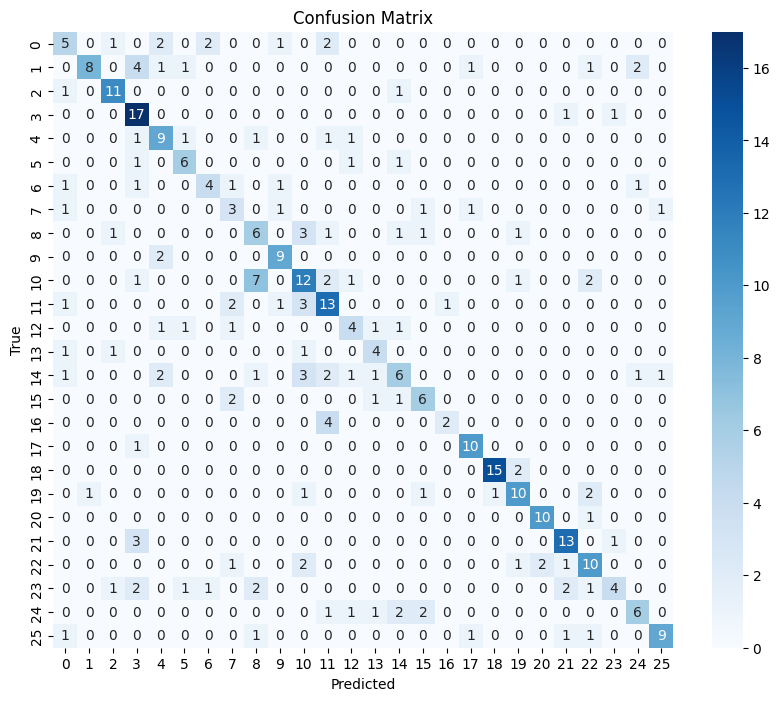

Akurasi: 59.55%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Membuat confusion matrix
cm = confusion_matrix(y_test, rf_pred)

# Membuat visualisasi confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menghitung akurasi model
accuracy = accuracy_score(y_test, rf_pred)
print("Akurasi: {:.2f}%".format(accuracy * 100))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Menentukan grid hiperparameter yang akan diuji
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Membuat model Random Forest
model = RandomForestClassifier(random_state=42)

# Membuat objek GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)

# Melatih model dengan grid search
grid_search.fit(X_train, y_train)

# Menampilkan kombinasi hiperparameter terbaik
print("Kombinasi Hiperparameter Terbaik:")
print(grid_search.best_params_)

# Evaluasi model dengan menggunakan kombinasi hiperparameter terbaik
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi dengan Hiperparameter Terbaik: {:.2f}%".format(accuracy * 100))

Kombinasi Hiperparameter Terbaik:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Akurasi dengan Hiperparameter Terbaik: 60.67%


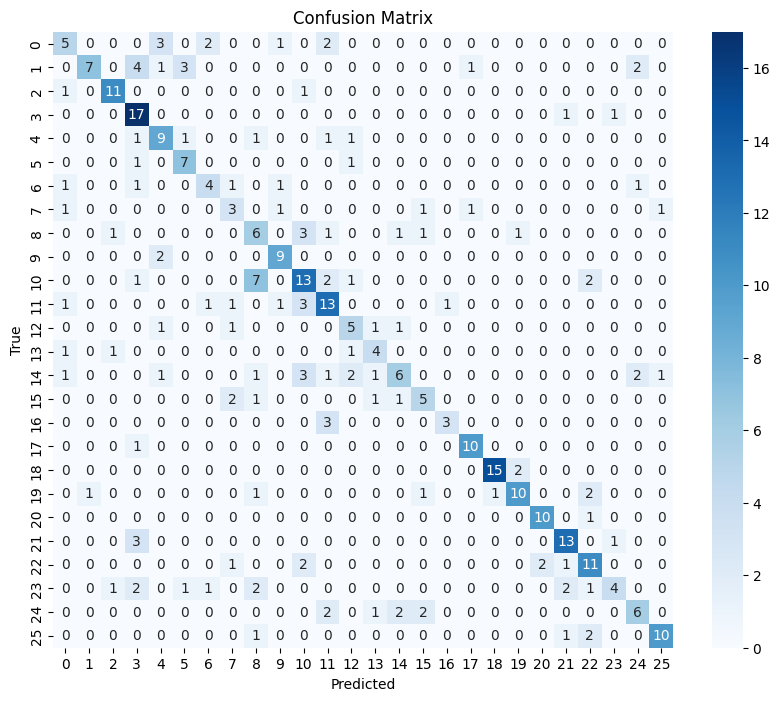

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Membuat visualisasi confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def load_data_and_extract_features():
    # Menentukan direktori induk yang berisi 26 folder dengan nama dari A sampai Z
    data_dir = 'Data Test/'

    # Inisialisasi array fitur dan label
    features = []
    labels = []

    # Loop melalui setiap folder
    label_mapping = {}
    for i, folder_name in enumerate(range(ord('A'), ord('Z')+1)):
        label_mapping[chr(folder_name)] = i

    for folder_name in range(ord('A'), ord('Z')+1):
        # Mendapatkan path ke folder
        folder_path = os.path.join(data_dir, chr(folder_name))

        # Loop melalui setiap file citra dalam folder
        for image_path in glob.glob(os.path.join(folder_path, '*.jpg')):
            # Membaca citra
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Ekstraksi fitur tekstur
            texture_features = extract_texture_features(image)

            # Ekstraksi fitur bentuk
            shape_features = extract_shape_features(image)

            # Gabungkan fitur tekstur dan bentuk
            combined_features = np.hstack([texture_features, shape_features])

            # Tambahkan fitur dan label ke array
            features.append(combined_features)

            # Mendapatkan label numerik dari nama folder (misal: folder "A" -> label 0)
            label = label_mapping[chr(folder_name)]
            labels.append(label)



    return features, labels

In [ ]:
new_features, new_labels = load_data_and_extract_features()
z = list(zip(new_features, new_labels))
new_features, new_labels = zip(*z)
new_features = np.asarray(new_features)
new_labels = np.asarray(new_labels)
# Menggunakan model yang telah dilatih untuk memprediksi label data baru
new_predictions = best_model.predict(new_features)

# Menghitung akurasi pada data baru
new_accuracy = accuracy_score(new_labels, new_predictions)
print("Akurasi pada Data Baru: {:.2f}%".format(new_accuracy * 100))

Akurasi pada Data Baru: 9.68%


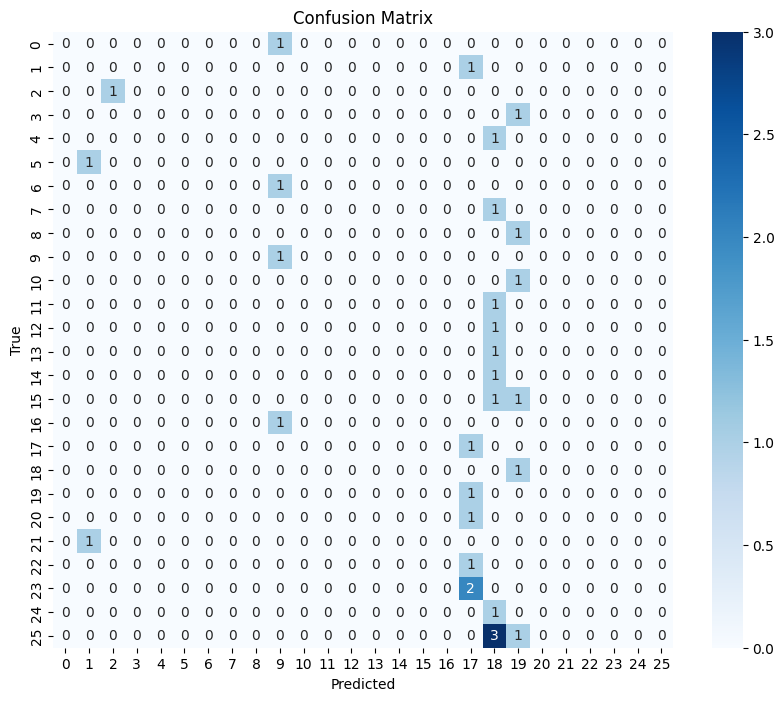

In [ ]:
cm = confusion_matrix(new_labels, new_predictions)

# Membuat visualisasi confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X_train[0]

array([ 3.87493913e+02,  4.41772654e+02,  8.16049052e+01,  4.77915560e+02,
        9.51741183e-01,  9.45022331e-01,  9.89873755e-01,  9.40524423e-01,
        1.28849943e-01,  1.25119769e-01,  1.36359337e-01,  1.24891118e-01,
        5.96487085e-01,  5.49405943e-01,  6.40741408e-01,  5.30582491e-01,
        1.69983846e-01,  1.11673025e-03,  8.82965556e-34,  2.20741389e-32,
       -9.74535216e-65,  0.00000000e+00,  0.00000000e+00])